In [ ]:
# PyTorch imports
import torch  # Main PyTorch library
import torch.nn as nn  # Neural network modules
import torch.optim as optim  # Optimization algorithms
#import torch.nn.functional as F  # Activation functions and other functional operations

import numpy as np # For matrix operations

# Data handling imports
from torch.utils.data import Dataset, DataLoader, random_split  # For dataset operations and data loading
from torchvision import datasets, transforms  # For vision datasets and image transformations

# Visualization and utility imports
import matplotlib.pyplot as plt  # For plotting graphs and images
import numpy as np  # For numerical operations
from tqdm import tqdm  # For progress bars in loops

In [ ]:
# Custom dataset class
class MNISTWithParity(Dataset):
    def __init__(self, mnist_dataset):
        # Initialize the class with the original MNIST dataset
        self.mnist_dataset = mnist_dataset
    
    def __len__(self):
        # Return the length of the dataset
        return len(self.mnist_dataset)
    
    def __getitem__(self, idx):
        # Get an item from the dataset by index
        image, label = self.mnist_dataset[idx]
        
        # Calculate parity (odd/even) of the label
        parity = label % 2  # 0 for even, 1 for odd
        
        # Determine if label is less than 5 or not
        threshold = 0 if label < 5 else 1
        
        # Return the image, and a tuple containing the original label, its parity, and the threshold value
        return image, (label, parity, threshold)

In [ ]:
# Modified CNN model for digit, parity, and threshold classification
class DigitParityCNN(nn.Module):
    def __init__(self):
        super(DigitParityCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2_digit = nn.Linear(128, 10)  # Digit classification (0-9)
        self.fc2_parity = nn.Linear(128, 2)  # Parity classification (odd/even)
        self.fc2_threshold = nn.Linear(128, 2)  # Threshold classification (<5 or >=5)
        
        # Additional layers
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Second convolutional block
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Third convolutional block
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Flatten the output for the fully connected layers
        x = self.flatten(x)
        
        # First fully connected layer
        x = self.fc1(x)
        x = self.relu(x)
        
        # Output layers
        digit_output = self.fc2_digit(x)
        parity_output = self.fc2_parity(x)
        threshold_output = self.fc2_threshold(x)
        
        return digit_output, parity_output, threshold_output

In [ ]:
# Hyperparameters
batch_size = 64        # Number of samples processed before the model is updated
learning_rate = 0.001  # Step size at each iteration while moving toward a minimum of the loss function
num_epochs = 10        # Number of complete passes through the training dataset
validation_split = 0.1 # Fraction of the training data to be used as validation data

In [ ]:
# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with MNIST mean and std dev
])

In [ ]:
# Load the MNIST dataset
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a custom dataset that includes parity information
custom_dataset = MNISTWithParity(mnist_dataset)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:01<00:00, 5614276.59it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 243416.91it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 2176953.39it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [ ]:
# Split dataset into training and validation sets
train_size = int((1 - validation_split) * len(custom_dataset))
val_size = len(custom_dataset) - train_size
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])

# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model and move it to the appropriate device (GPU or CPU)
model = DigitParityCNN().to(device)

In [ ]:
# Loss and optimizer setup

# Loss function for digit classification
criterion_digit = nn.CrossEntropyLoss()

# Loss function for parity classification
criterion_parity = nn.CrossEntropyLoss()

# Loss function for threshold classification
criterion_threshold = nn.CrossEntropyLoss()

# Adam optimizer for updating model parameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

Epoch [1/10], Train Loss: 0.3155, Val Loss: 0.1247
Train Digit Acc: 95.17%, Train Parity Acc: 96.92%, Train Threshold Acc: 96.67%
Val Digit Acc: 98.25%, Val Parity Acc: 98.97%, Val Threshold Acc: 98.60%


Epoch [2/10], Train Loss: 0.0751, Val Loss: 0.0825
Train Digit Acc: 98.92%, Train Parity Acc: 99.33%, Train Threshold Acc: 99.24%
Val Digit Acc: 98.88%, Val Parity Acc: 99.37%, Val Threshold Acc: 99.13%


Epoch [3/10], Train Loss: 0.0423, Val Loss: 0.0774
Train Digit Acc: 99.44%, Train Parity Acc: 99.63%, Train Threshold Acc: 99.57%
Val Digit Acc: 98.93%, Val Parity Acc: 99.40%, Val Threshold Acc: 99.22%


Epoch [4/10], Train Loss: 0.0279, Val Loss: 0.0680
Train Digit Acc: 99.66%, Train Parity Acc: 99.79%, Train Threshold Acc: 99.74%
Val Digit Acc: 99.10%, Val Parity Acc: 99.40%, Val Threshold Acc: 99.37%


Epoch [5/10], Train Loss: 0.0198, Val Loss: 0.0670
Train Digit Acc: 99.78%, Train Parity Acc: 99.88%, Train Threshold Acc: 99.81%
Val Digit Acc: 99.10%, Val Parity Acc: 99.52%, Val Threshold Acc: 99.40%


Epoch [6/10], Train Loss: 0.0160, Val Loss: 0.0723
Train Digit Acc: 99.83%, Train Parity Acc: 99.92%, Train Threshold Acc: 99.86%
Val Digit Acc: 99.00%, Val Parity Acc: 99.45%, Val Threshold Acc: 99.35%


Epoch [7/10], Train Loss: 0.0142, Val Loss: 0.0694
Train Digit Acc: 99.85%, Train Parity Acc: 99.93%, Train Threshold Acc: 99.88%
Val Digit Acc: 99.07%, Val Parity Acc: 99.43%, Val Threshold Acc: 99.38%


Epoch [8/10], Train Loss: 0.0132, Val Loss: 0.0699
Train Digit Acc: 99.87%, Train Parity Acc: 99.93%, Train Threshold Acc: 99.89%
Val Digit Acc: 99.03%, Val Parity Acc: 99.48%, Val Threshold Acc: 99.33%


Epoch [9/10], Train Loss: 0.0127, Val Loss: 0.0692
Train Digit Acc: 99.87%, Train Parity Acc: 99.94%, Train Threshold Acc: 99.90%
Val Digit Acc: 99.07%, Val Parity Acc: 99.45%, Val Threshold Acc: 99.42%


Epoch [10/10], Train Loss: 0.0124, Val Loss: 0.0695
Train Digit Acc: 99.88%, Train Parity Acc: 99.94%, Train Threshold Acc: 99.90%
Val Digit Acc: 99.07%, Val Parity Acc: 99.48%, Val Threshold Acc: 99.38%


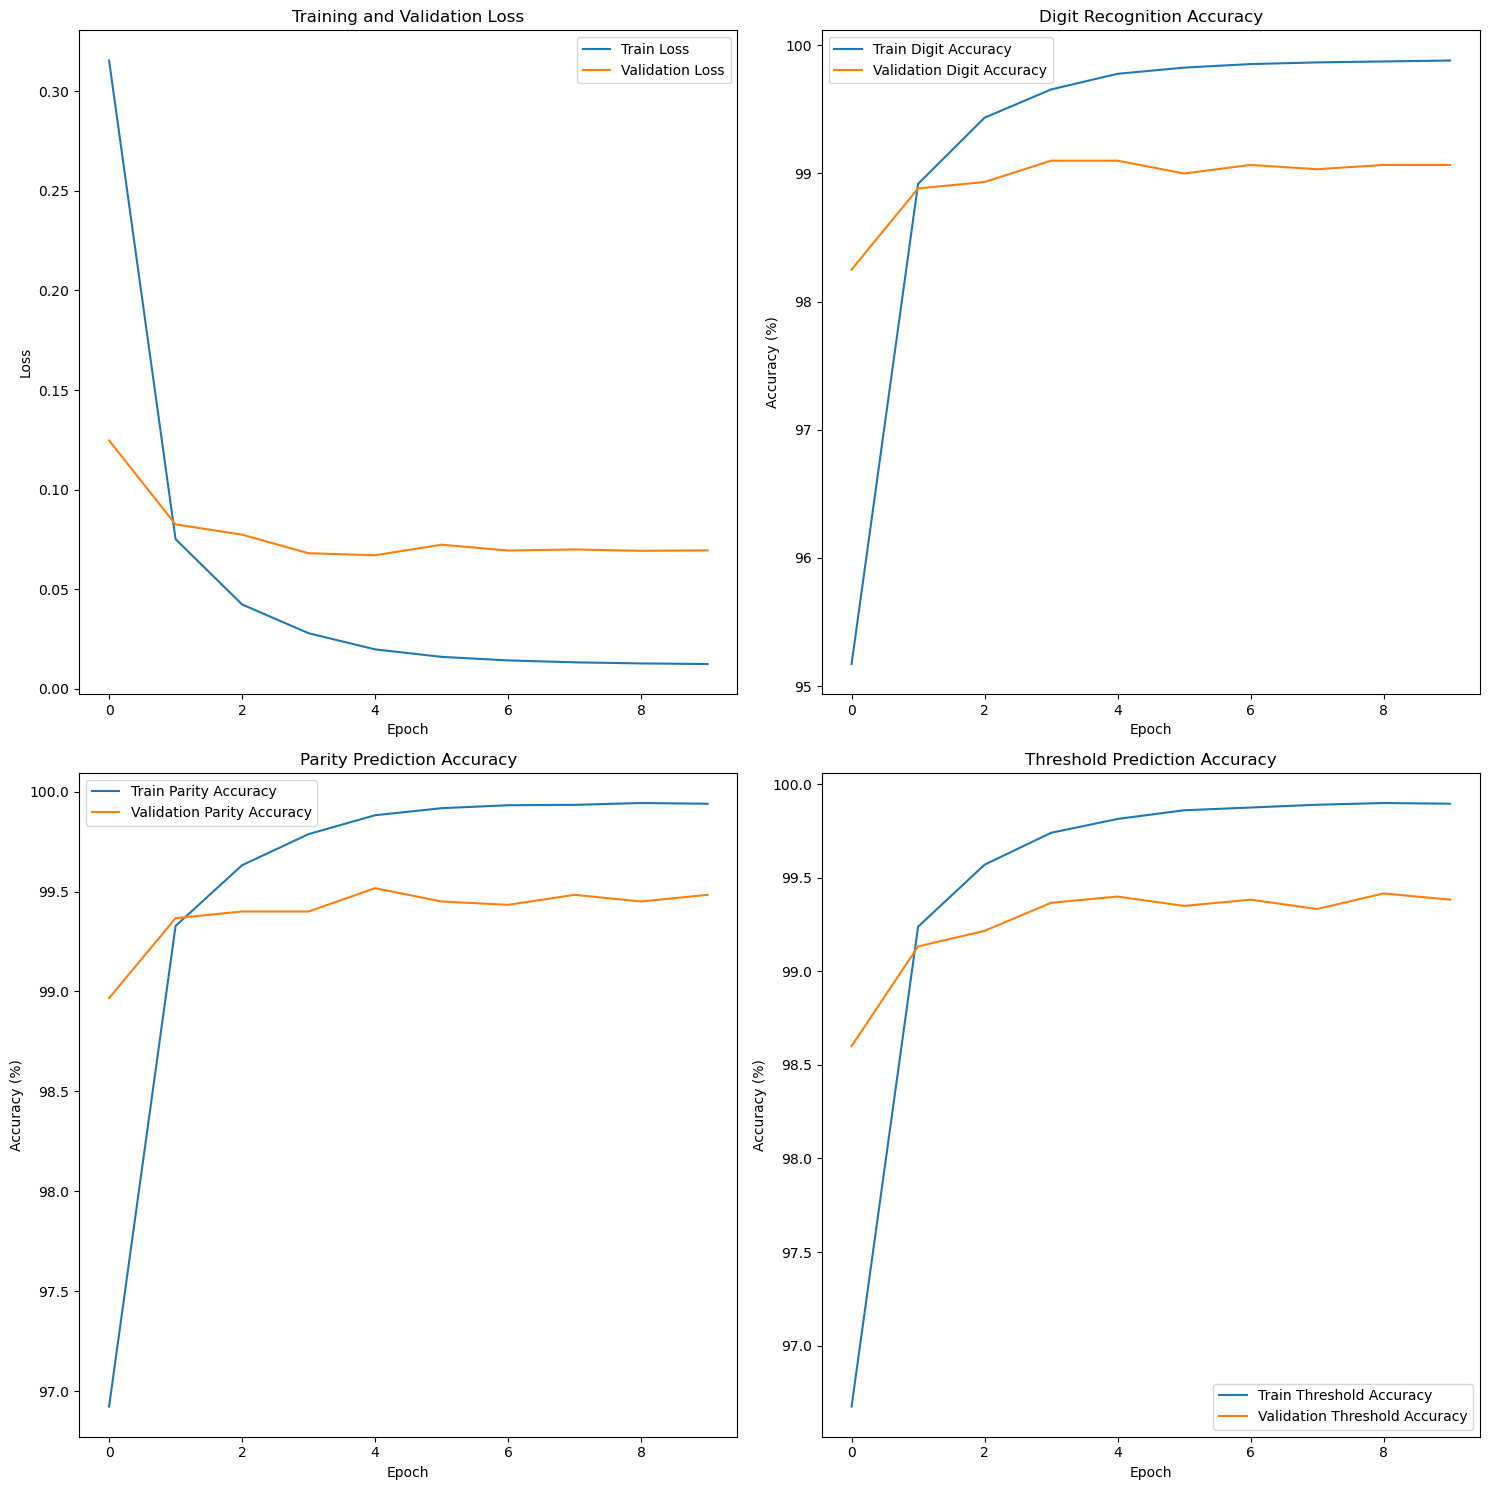

In [ ]:
# Initialize lists to store training and validation metrics
train_losses, val_losses = [], []
train_digit_accuracies, train_parity_accuracies, train_threshold_accuracies = [], [], []
val_digit_accuracies, val_parity_accuracies, val_threshold_accuracies = [], [], []

# Initialize variables for tracking the best model
best_val_loss = float('inf')
best_model_path = 'best_model_digit_parity_threshold.pth'

# Main training loop
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    
    # Initialize metrics for this epoch
    running_loss = 0.0
    correct_digits, correct_parities, correct_thresholds, total = 0, 0, 0, 0
    
    # Create a progress bar for the training data
    train_loader_tqdm = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] - Training', leave=False, ascii=True)
    
    # Iterate over batches in the training data
    for images, (labels, parities, thresholds) in train_loader_tqdm:
        # Move the batch data to the appropriate device
        images, labels, parities, thresholds = images.to(device), labels.to(device), parities.to(device), thresholds.to(device)
        
        # Zero out the gradients
        optimizer.zero_grad()
        
        # Forward pass: compute the model output
        digit_outputs, parity_outputs, threshold_outputs = model(images)
        
        # Compute the loss
        loss_digit = criterion_digit(digit_outputs, labels)
        loss_parity = criterion_parity(parity_outputs, parities)
        loss_threshold = criterion_threshold(threshold_outputs, thresholds)
        loss = loss_digit + loss_parity + loss_threshold
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate the batch loss
        running_loss += loss.item()
        
        # Compute accuracies for this batch
        _, predicted_digits = torch.max(digit_outputs, 1)
        _, predicted_parities = torch.max(parity_outputs, 1)
        _, predicted_thresholds = torch.max(threshold_outputs, 1)
        total += labels.size(0)
        correct_digits += (predicted_digits == labels).sum().item()
        correct_parities += (predicted_parities == parities).sum().item()
        correct_thresholds += (predicted_thresholds == thresholds).sum().item()
        
        # Update the progress bar
        train_loader_tqdm.set_postfix({'Train Loss': f'{loss.item():8.4f}'})
    
    # Compute average loss and accuracies for this epoch
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_digit_accuracy = 100 * correct_digits / total
    train_parity_accuracy = 100 * correct_parities / total
    train_threshold_accuracy = 100 * correct_thresholds / total
    train_digit_accuracies.append(train_digit_accuracy)
    train_parity_accuracies.append(train_parity_accuracy)
    train_threshold_accuracies.append(train_threshold_accuracy)
    
    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct_digits, correct_parities, correct_thresholds, total = 0, 0, 0, 0
    
    val_loader_tqdm = tqdm(val_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] - Validation', leave=False, ascii=True)
    
    with torch.no_grad():
        for images, (labels, parities, thresholds) in val_loader_tqdm:
            images, labels, parities, thresholds = images.to(device), labels.to(device), parities.to(device), thresholds.to(device)
            
            digit_outputs, parity_outputs, threshold_outputs = model(images)
            
            loss_digit = criterion_digit(digit_outputs, labels)
            loss_parity = criterion_parity(parity_outputs, parities)
            loss_threshold = criterion_threshold(threshold_outputs, thresholds)
            loss = loss_digit + loss_parity + loss_threshold
            val_loss += loss.item()
            
            _, predicted_digits = torch.max(digit_outputs, 1)
            _, predicted_parities = torch.max(parity_outputs, 1)
            _, predicted_thresholds = torch.max(threshold_outputs, 1)
            total += labels.size(0)
            correct_digits += (predicted_digits == labels).sum().item()
            correct_parities += (predicted_parities == parities).sum().item()
            correct_thresholds += (predicted_thresholds == thresholds).sum().item()
            
            val_loader_tqdm.set_postfix({'Val Loss': f"{loss.item():8.4f}"})
    
    # Compute average validation loss and accuracies
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_digit_accuracy = 100 * correct_digits / total
    val_parity_accuracy = 100 * correct_parities / total
    val_threshold_accuracy = 100 * correct_thresholds / total
    val_digit_accuracies.append(val_digit_accuracy)
    val_parity_accuracies.append(val_parity_accuracy)
    val_threshold_accuracies.append(val_threshold_accuracy)
    
    # Print the results for this epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    print(f'Train Digit Acc: {train_digit_accuracy:.2f}%, Train Parity Acc: {train_parity_accuracy:.2f}%, Train Threshold Acc: {train_threshold_accuracy:.2f}%')
    print(f'Val Digit Acc: {val_digit_accuracy:.2f}%, Val Parity Acc: {val_parity_accuracy:.2f}%, Val Threshold Acc: {val_threshold_accuracy:.2f}%')
    
    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'best_val_loss': best_val_loss,
        }, best_model_path)
    
    # Step the learning rate scheduler
    scheduler.step()

# Visualization of training results
plt.figure(figsize=(15, 15))

# Plot 1: Training and Validation Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot 2: Digit Recognition Accuracy
plt.subplot(2, 2, 2)
plt.plot(train_digit_accuracies, label='Train Digit Accuracy')
plt.plot(val_digit_accuracies, label='Validation Digit Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Digit Recognition Accuracy')

# Plot 3: Parity Prediction Accuracy
plt.subplot(2, 2, 3)
plt.plot(train_parity_accuracies, label='Train Parity Accuracy')
plt.plot(val_parity_accuracies, label='Validation Parity Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Parity Prediction Accuracy')

# Plot 4: Threshold Prediction Accuracy
plt.subplot(2, 2, 4)
plt.plot(train_threshold_accuracies, label='Train Threshold Accuracy')
plt.plot(val_threshold_accuracies, label='Validation Threshold Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Threshold Prediction Accuracy')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [ ]:
# Load the best model for testing

# Load the MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Wrap the MNIST test dataset with our custom MNISTWithParity dataset
# This adds parity information to each sample
test_dataset = MNISTWithParity(test_dataset)

# Create a DataLoader for the test dataset
# We use shuffle=False for testing to maintain the original order of the dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the saved checkpoint of the best model
# This checkpoint was saved during training when the model achieved the lowest validation loss
checkpoint = torch.load(best_model_path)

# Restore the model's state from the checkpoint
# This sets the model's parameters to the values that achieved the best validation performance
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
# This disables dropout and sets batch normalization to use running statistics
model.eval()

D:\Temp\ipykernel_17448\1892745261.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)


DigitParityCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2_digit): Linear(in_features=128, out_features=10, bias=True)
  (fc2_parity): Linear(in_features=128, out_features=2, bias=True)
  (fc2_threshold): Linear(in_features=128, out_features=2, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
def confusion_matrix(y_true, y_pred, num_classes):
    # Initialize a zero-filled matrix of size num_classes x num_classes
    # np.zeros creates a 2D array filled with zeros
    # The shape is (num_classes, num_classes)
    # dtype=int specifies that the array should contain integers
    cm = np.zeros((num_classes, num_classes), dtype=int)
    
    # Iterate through true and predicted labels simultaneously
    # zip(y_true, y_pred) pairs up corresponding elements from y_true and y_pred
    for true, pred in zip(y_true, y_pred):
        # Increment the count at the corresponding position in the matrix
        # true is used as the row index, pred as the column index
        # += 1 increments the count by 1 for each occurrence
        cm[true][pred] += 1
    
    # Return the completed confusion matrix
    # After all iterations, cm contains the counts of all (true, predicted) combinations
    return cm

In [ ]:
def plot_confusion_matrix(cm, title, labels=None):
    # Create a new figure and axis with specified size
    fig, ax = plt.subplots(figsize=(6, 5))
    
    # Display the confusion matrix as an image
    # 'nearest' interpolation means no interpolation between pixels
    # plt.cm.Blues is a blue color map
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    # Add a colorbar to the plot, using the current axes
    ax.figure.colorbar(im, ax=ax)
    
    # Set various properties of the axis
    ax.set(
        xticks=np.arange(cm.shape[1]),  # Set x-axis ticks to match matrix columns
        yticks=np.arange(cm.shape[0]),  # Set y-axis ticks to match matrix rows
        title=title,  # Set the title of the plot
        ylabel='True label',  # Label for y-axis
        xlabel='Predicted label'  # Label for x-axis
    )
    
    # If labels are provided, use them for x and y axis
    if labels:
        ax.set_xticklabels(labels)  # Set labels for x-axis ticks
        ax.set_yticklabels(labels)  # Set labels for y-axis ticks
    
    # Rotate the tick labels on x-axis and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Calculate threshold for text color (white or black)
    # Values above thresh will be white, below will be black
    thresh = cm.max() / 2.
    
    # Add text annotations to each cell in the plot
    for i in range(cm.shape[0]):  # Iterate over rows
        for j in range(cm.shape[1]):  # Iterate over columns
            # Add text annotation for each cell
            ax.text(j, i, format(cm[i, j], 'd'),  # Position and value to display
                    ha="center", va="center",  # Center alignment
                    color="white" if cm[i, j] > thresh else "black")  # Choose text color based on cell value
    
    # Adjust the layout to prevent clipping of tick-labels
    fig.tight_layout()
    
    # Return the figure object
    return fig

In [ ]:
def test_model(model, test_loader, device, criterion_digit, criterion_parity, criterion_threshold):
    model.eval()
    
    test_loss = 0.0
    correct_digit = 0
    correct_parity = 0
    correct_threshold = 0
    total = 0
    
    all_digit_preds = []
    all_digit_labels = []
    all_parity_preds = []
    all_parity_labels = []
    all_threshold_preds = []
    all_threshold_labels = []
    
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []
    
    test_loader_tqdm = tqdm(test_loader, desc="Testing", leave=False, ascii=True)
    
    with torch.no_grad():
        for images, (labels, parities, thresholds) in test_loader_tqdm:
            images, labels, parities, thresholds = images.to(device), labels.to(device), parities.to(device), thresholds.to(device)
            
            digit_outputs, parity_outputs, threshold_outputs = model(images)
            
            loss_digit = criterion_digit(digit_outputs, labels)
            loss_parity = criterion_parity(parity_outputs, parities)
            loss_threshold = criterion_threshold(threshold_outputs, thresholds)
            loss = loss_digit + loss_parity + loss_threshold
            
            test_loss += loss.item()
            
            _, predicted_digit = torch.max(digit_outputs.data, 1)
            _, predicted_parity = torch.max(parity_outputs.data, 1)
            _, predicted_threshold = torch.max(threshold_outputs.data, 1)
            
            total += labels.size(0)
            correct_digit += (predicted_digit == labels).sum().item()
            correct_parity += (predicted_parity == parities).sum().item()
            correct_threshold += (predicted_threshold == thresholds).sum().item()
            
            all_digit_preds.extend(predicted_digit.cpu().numpy())
            all_digit_labels.extend(labels.cpu().numpy())
            all_parity_preds.extend(predicted_parity.cpu().numpy())
            all_parity_labels.extend(parities.cpu().numpy())
            all_threshold_preds.extend(predicted_threshold.cpu().numpy())
            all_threshold_labels.extend(thresholds.cpu().numpy())
            
            for i in range(len(labels)):
                if predicted_digit[i] != labels[i] or predicted_parity[i] != parities[i] or predicted_threshold[i] != thresholds[i]:
                    misclassified_images.append(images[i].cpu())
                    misclassified_labels.append((labels[i].cpu(), parities[i].cpu(), thresholds[i].cpu()))
                    misclassified_preds.append((predicted_digit[i].cpu(), predicted_parity[i].cpu(), predicted_threshold[i].cpu()))
    
    test_loss /= len(test_loader)
    accuracy_digit = 100 * correct_digit / total
    accuracy_parity = 100 * correct_parity / total
    accuracy_threshold = 100 * correct_threshold / total
    
    print(f'Test Loss: {test_loss:.4f}, Digit Accuracy: {accuracy_digit:.2f}%, Parity Accuracy: {accuracy_parity:.2f}%, Threshold Accuracy: {accuracy_threshold:.2f}%')
    
    cm_digit = confusion_matrix(all_digit_labels, all_digit_preds, num_classes=10)
    cm_parity = confusion_matrix(all_parity_labels, all_parity_preds, num_classes=2)
    cm_threshold = confusion_matrix(all_threshold_labels, all_threshold_preds, num_classes=2)
    
    plot_confusion_matrix(cm_digit, 'Digit Confusion Matrix', labels=range(10))
    plt.figure()
    plot_confusion_matrix(cm_parity, 'Parity Confusion Matrix', labels=['Even', 'Odd'])
    plt.figure()
    plot_confusion_matrix(cm_threshold, 'Threshold Confusion Matrix', labels=['<5', '>=5'])
    plt.show()
    
    return test_loss, accuracy_digit, accuracy_parity, accuracy_threshold, misclassified_images, misclassified_labels, misclassified_preds

Test Loss: 0.0518, Digit Accuracy: 99.24%, Parity Accuracy: 99.56%, Threshold Accuracy: 99.46%


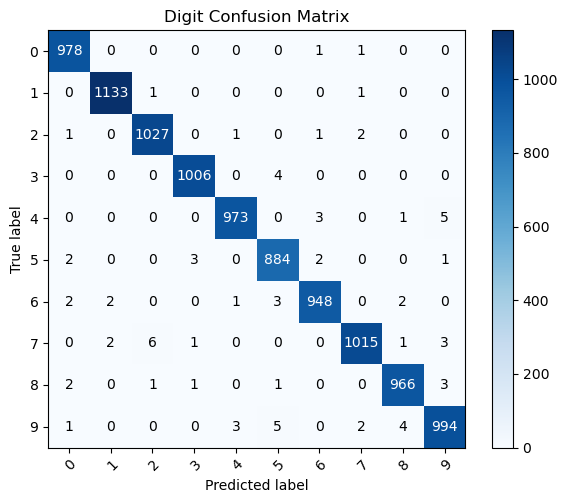

<Figure size 640x480 with 0 Axes>

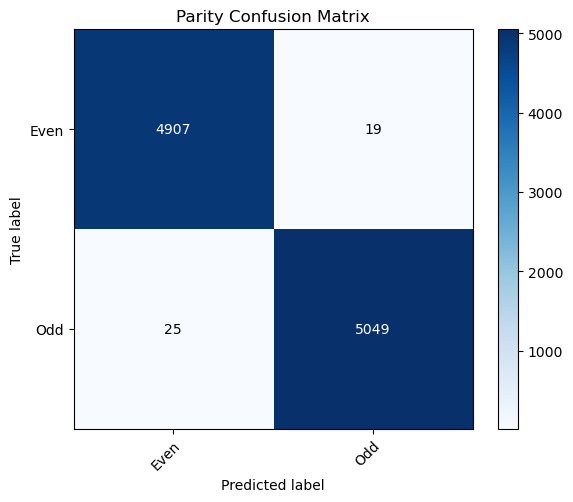

<Figure size 640x480 with 0 Axes>

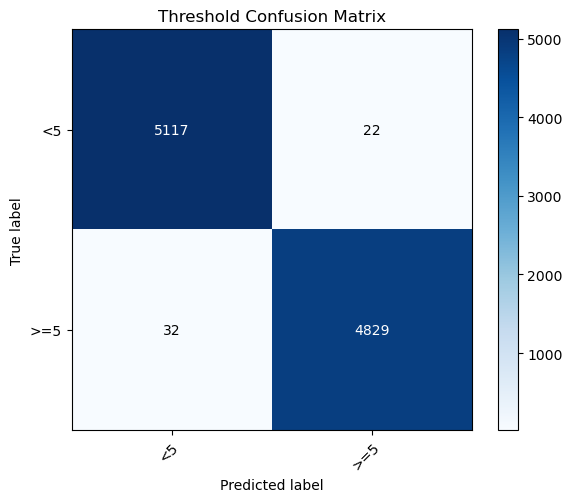

In [ ]:
test_loss, accuracy_digit, accuracy_parity, accuracy_threshold, misclassified_images, misclassified_labels, misclassified_preds = test_model(model, test_loader, device, criterion_digit, criterion_parity, criterion_threshold)

In [ ]:
# Function to display images
def imshow(img, title):
    img = img / 2 + 0.5
    
    # Convert the image tensor to a numpy array
    npimg = img.numpy()
    
    # Transpose the dimensions to match matplotlib's expected format
    # From (channels, height, width) to (height, width, channels)
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    
    # Set the title of the plot
    plt.title(title)
    
    # Display the image
    plt.show()

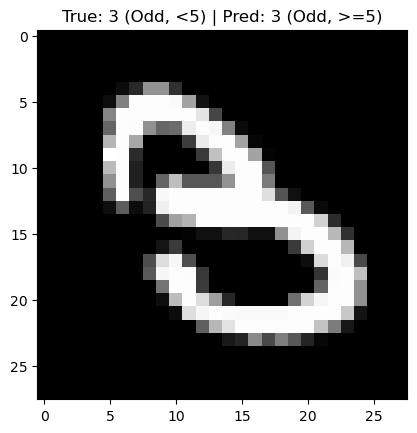

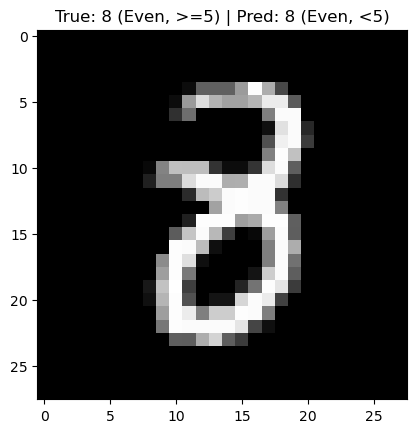

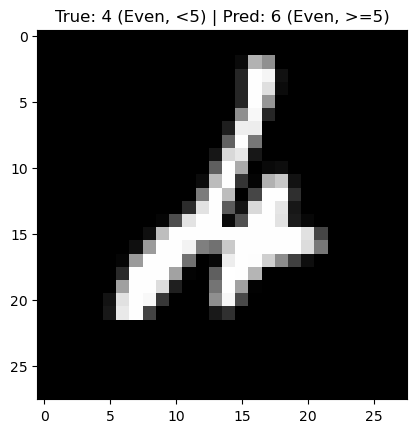

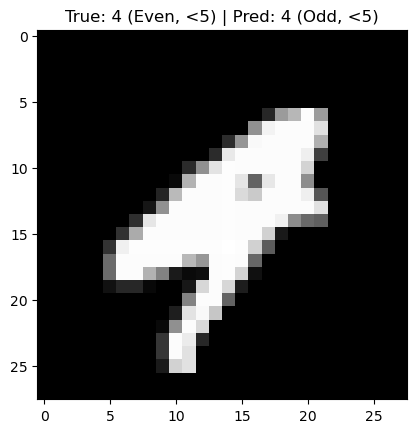

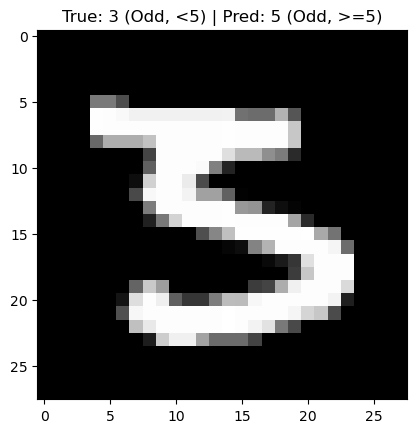

In [ ]:
# Show a few misclassified images
for i in range(5):  # Loop through the first 5 misclassified images
    # Extract true labels, parities, and thresholds
    true_label, true_parity, true_threshold = misclassified_labels[i]
    
    # Extract predicted labels, parities, and thresholds
    pred_label, pred_parity, pred_threshold = misclassified_preds[i]
    
    # Create strings for true and predicted labels
    true_str = f'{true_label.item()} ({["Even", "Odd"][true_parity.item()]}, {["<5", ">=5"][true_threshold.item()]})'
    pred_str = f'{pred_label.item()} ({["Even", "Odd"][pred_parity.item()]}, {["<5", ">=5"][pred_threshold.item()]})'
    
    # Display the image using the custom imshow function
    imshow(misclassified_images[i],
           f'True: {true_str} | Pred: {pred_str}')